# Heart Rate and Calories Expenditure OLS Models

In [3]:
from google.colab import drive
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# drive.mount('/content/drive') #(only if being used on colab)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load in sample from entire dataset - generated from EDA notebook

In [104]:
# meta_with_hr = pd.read_csv("/content/drive/MyDrive/meta_with_hr.csv").drop(columns=["Unnamed: 0"]) #(for colab)
meta_with_hr = pd.read_csv("../data/meta_with_hr.csv").drop(columns=["Unnamed: 0"]) # (THIS IS ON THE GOOGLE DRIVE LINK, TOO BIG TO INCLUDE)
meta_with_hr["heart_rate"] = meta_with_hr["heart_rate"].apply(ast.literal_eval)
meta_with_hr

,userId,hydration,sport,ascent,descent,calories,duration,id,timestamp,distance,url,weather,gender,heart_rate,mean_hr
0,10057948,NaN,run,35.0,39.0,290.0000,2055.569,650275494,"['2015-12-19T13:53:50.000Z', '2015-12-19T13:53...",3.90636,https://www.endomondo.com/users/10057948/worko...,{'type': 7},male,"[87, 90, 92, 92, 99, 99, 102, 102, 102, 109, 1...",133.750000
1,10057948,NaN,bike,88.0,88.0,0.0000,3525.000,628648767,"['2015-11-05T21:20:11.000Z', '2015-11-05T21:20...",22.39755,https://www.endomondo.com/users/10057948/worko...,NaN,male,"[90, 93, 92, 91, 97, 95, 96, 97, 98, 97, 99, 1...",119.832000
2,10057948,NaN,bike,344.0,355.0,685.0000,5875.821,617014137,"['2015-10-11T12:43:59.000Z', '2015-10-11T12:44...",36.73035,https://www.endomondo.com/users/10057948/worko...,{'type': 4},male,"[65, 83, 85, 85, 75, 83, 75, 68, 76, 84, 92, 9...",117.498000
3,10057948,NaN,bike,392.0,378.0,677.0000,4986.544,612513349,"['2015-10-03T14:04:24.000Z', '2015-10-03T14:07...",39.90147,https://www.endomondo.com/users/10057948/worko...,NaN,male,"[80, 106, 121, 122, 116, 121, 133, 137, 134, 1...",143.536000
4,10057948,NaN,run,28.0,29.0,324.0000,2569.248,606775044,"['2015-09-23T10:30:36.000Z', '2015-09-23T10:30...",3.13272,https://www.endomondo.com/users/10057948/worko...,NaN,male,"[71, 74, 74, 77, 79, 80, 84, 92, 95, 95, 100, ...",121.392000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,982359,NaN,mountain bike,476.0,476.0,1637.5600,5548.000,117437355,"['2013-01-06T09:29:22.000Z', '2013-01-06T09:34...",23.36000,https://www.endomondo.com/users/982359/workout...,"{'type': 7, 'humidity': 100, 'wind_direction':...",male,"[89, 106, 101, 117, 125, 133, 130, 142, 149, 1...",162.496000
9997,982359,NaN,bike (transport),42.0,33.0,142.1930,760.000,117437436,"['2013-01-06T09:06:35.000Z', '2013-01-06T09:06...",4.34000,https://www.endomondo.com/users/982359/workout...,"{'type': 7, 'humidity': 100, 'wind_direction':...",male,"[87, 88, 93, 93, 96, 97, 99, 100, 101, 100, 98...",119.658000
9998,982359,NaN,elliptical,2.0,5.0,196.1910,785.000,116934249,"['2013-01-04T19:48:32.000Z', '2013-01-04T19:48...",3.40000,https://www.endomondo.com/users/982359/workout...,"{'type': 11, 'humidity': 100, 'wind_direction'...",male,"[78, 79, 80, 84, 85, 86, 86, 87, 88, 91, 94, 9...",145.300000
9999,982359,NaN,bike,80.0,80.0,733.7720,2486.000,116459008,"['2013-01-02T19:29:36.000Z', '2013-01-02T19:31...",18.99000,https://www.endomondo.com/users/982359/workout...,"{'type': 7, 'humidity': 93, 'wind_direction': ...",male,"[75, 78, 80, 86, 97, 101, 105, 109, 111, 116, ...",153.402000


#### Drop columns that won't be used, as well as any NaN/null rows

In [105]:
data = meta_with_hr.drop(columns=["userId", "hydration", "id", "timestamp", "url", "weather", "heart_rate"])
data = data.dropna()

#### Function that will be used for normalizing and one-hot encoding the features

In [70]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def process_data(data):
  """
  Function that normalizes numerical columns and one-hot encodes categorical columns.

  Params
  ------
  data: pd.DataFrame
    Dataframe to be processed, already filtered to exclude unwanted columns.

  Returns
  -------
  data: pd.DataFrame
    Processed dataframe.
  """
  # seperate the columns into categorical and quantitative
  cat = data.select_dtypes(include=["object"])
  quant = data.select_dtypes(include=["number"])

  # normalize quantitative columns using StandardScaler
  scaler = StandardScaler()
  data[quant.columns] = scaler.fit_transform(quant)

  # one-hot encode categorical columns using OneHotEncoder
  ohe = OneHotEncoder(sparse=False, drop=None)
  cat_encoded = ohe.fit_transform(cat)
  cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(cat.columns))

  # combine the dataframes back together
  data.reset_index(drop=True, inplace=True)
  cat_encoded_df.reset_index(drop=True, inplace=True)
  data = pd.concat([data[quant.columns], cat_encoded_df], axis=1)

  return data

## Model 1: Predicting Average Heart Rate

In [106]:
# extract the Y values (average heart rate) and process the data
y = data["mean_hr"]
data = process_data(data.drop("mean_hr", axis=1))
data

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ascent,descent,calories,duration,distance,sport_bike,sport_bike (transport),sport_core stability training,sport_cross-country skiing,sport_elliptical,...,sport_rowing,sport_run,sport_skate,sport_stair climing,sport_tennis,sport_walk,sport_weight training,gender_female,gender_male,gender_unknown
0,-0.277632,-0.270104,-0.010031,-0.534645,-0.746717,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.174787,-0.175664,-0.010044,-0.229728,-0.094009,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.321974,0.338933,-0.010012,0.258083,0.411915,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.415117,0.383261,-0.010013,0.073552,0.523851,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.291215,-0.289377,-0.010029,-0.428053,-0.774026,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.578116,0.572140,-0.009968,0.190058,-0.060036,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9986,-0.264048,-0.281668,-0.010038,-0.803484,-0.731411,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9987,-0.341667,-0.335633,-0.010035,-0.798297,-0.764591,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9988,-0.190311,-0.191083,-0.010010,-0.445328,-0.214290,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [107]:
from sklearn.model_selection import train_test_split

# split data into training and testing
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
from sklearn.linear_model import LinearRegression

# initialize model and fit to training data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [109]:
from sklearn.metrics import mean_squared_error

# MSE for training predictions
y_pred = model.predict(X_train)
mean_squared_error(y_train, y_pred)

229.78735602763896

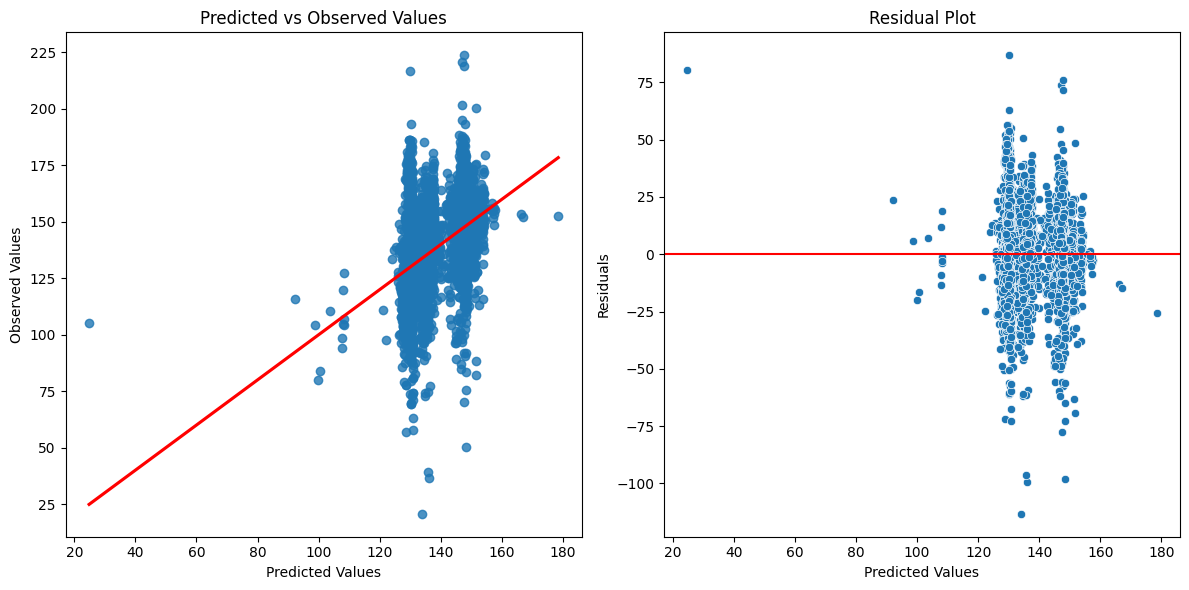

In [110]:
# plot the obs. vs pred. and residuals

plt.figure(figsize=(12,6))
plt.subplot(121)
# 1. plot predictions vs. observations
sns.regplot(x=y_pred, y=y_train, ci=None, line_kws={'color':'red'});
plt.title("Predicted vs Observed Values")
plt.xlabel("Predicted Values")
plt.ylabel("Observed Values")

plt.subplot(122)
# 2. plot residual plot
sns.scatterplot(x=y_pred, y=y_train - y_pred)
plt.axhline(y=0, color='red')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.tight_layout()

From the plots above, it is likely that the outliers in the dataset are affecting model. Therefore, we will further process the training data.

Process data again, removing outliers

In [111]:
# try again with removed outliers
data = meta_with_hr.drop(columns=["userId", "hydration", "id", "timestamp", "url", "weather", "heart_rate"])
data = data.dropna()
data = data[data["calories"] < 5000]
data = data[data["calories"] > 10]
data = data[data["mean_hr"] >= 60]
data = data[data["mean_hr"] <= 200]
y = data["mean_hr"]
data = data.drop(columns=["mean_hr", "calories"])
data = data.dropna()
data

,sport,ascent,descent,duration,distance,gender
0,run,35.0,39.0,2055.569,3.90636,male
2,bike,344.0,355.0,5875.821,36.73035,male
3,bike,392.0,378.0,4986.544,39.90147,male
4,run,28.0,29.0,2569.248,3.13272,male
5,bike,163.0,167.0,2806.428,21.47972,male
...,...,...,...,...,...,...
9996,mountain bike,476.0,476.0,5548.000,23.36000,male
9997,bike (transport),42.0,33.0,760.000,4.34000,male
9998,elliptical,2.0,5.0,785.000,3.40000,male
9999,bike,80.0,80.0,2486.000,18.99000,male


In [112]:
data = process_data(data)
data

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ascent,descent,duration,distance,sport_bike,sport_bike (transport),sport_core stability training,sport_cross-country skiing,sport_elliptical,sport_hiking,...,sport_mountain bike,sport_orienteering,sport_rowing,sport_run,sport_skate,sport_walk,sport_weight training,gender_female,gender_male,gender_unknown
0,-0.273017,-0.265528,-0.645832,-0.748408,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.324784,0.340836,0.346533,0.432389,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.417646,0.384971,0.115530,0.546465,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.286559,-0.284717,-0.512397,-0.776238,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.025384,-0.019912,-0.450786,-0.116231,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9751,0.580155,0.573020,0.261376,-0.048591,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9752,-0.259475,-0.277042,-0.982375,-0.732808,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9753,-0.336860,-0.330770,-0.975881,-0.766623,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9754,-0.185959,-0.186854,-0.534022,-0.205795,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [116]:
# train data using 3-fold cross validation and calculate the avg. validation error
# ensure that we're not overfitting to training data

X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=3, shuffle=True)
hr_model = LinearRegression()
val_errors = []
train_errors = []
for train_idx, valid_idx in kf.split(X_train):

    # split into train and validation sets
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # fit the model
    hr_model.fit(split_X_train, split_Y_train)

    # calculate and store the training error
    error = mean_squared_error(hr_model.predict(split_X_train), split_Y_train)
    train_errors.append(error)

    # calculate and store the validation error
    error = mean_squared_error(hr_model.predict(split_X_valid), split_Y_valid)
    val_errors.append(error)
print(f"Train error: {np.mean(train_errors)}")
print(f"Cross-validation error: {np.mean(val_errors)}")

Train error: 205.09373448207202
Cross-validation error: 207.21230331083197


In [117]:
# Calculate the RMSE on the test set
hr_model.fit(X_train, y_train)
y_pred = hr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

14.840472602777739

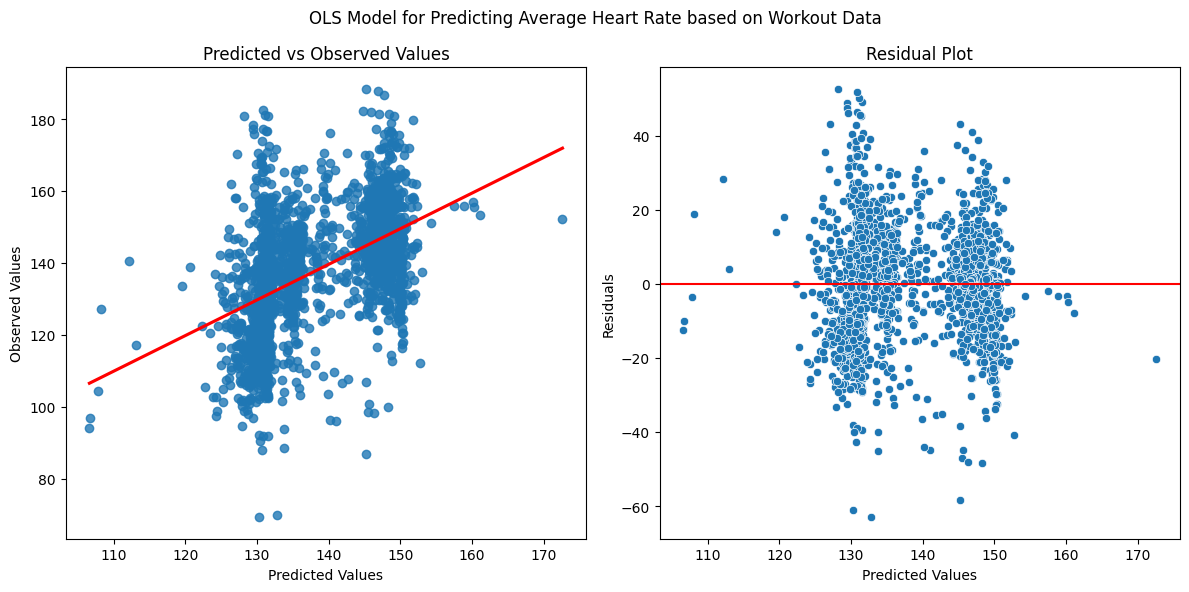

In [118]:
# plot the predicted vs. observed values and the residual plot

plt.figure(figsize=(12,6))      # do not change this line
plt.subplot(121)                # do not change this line
# 1. plot predictions vs. observations
sns.regplot(x=y_pred, y=y_test, ci=None, line_kws={'color':'red'});
plt.title("Predicted vs Observed Values")
plt.xlabel("Predicted Values")
plt.ylabel("Observed Values")

plt.subplot(122)               # do not change this line
# 2. plot residual plot
sns.scatterplot(x=y_pred, y=y_test - y_pred)
plt.axhline(y=0, color='red')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.suptitle("OLS Model for Predicting Average Heart Rate based on Workout Data")
plt.tight_layout()
plt.savefig("../figures/avg_hr_ols.png")

As shown by the plots above, the linear regression model is generally failing to capture any relationships between the features and the average heart rate. It seems to be predicting calories within a set range for a majority of the data points, between 120 and 150. It is likely that these features alone cannot accurately predict average heart rate, as it generally has less to do with workout metrics and more to do with the user's personal health metrics, which are generally unavailable in this dataset (i.e. height, weight, age, etc.). Alternatively, it could be that there are non-linear relationships that are not being captured. This is the motivation for the neural network approach.

#### Creating a model for maximum heart rate prediction


This model was just for exploratory purposes, to see whether a linear regression model was better at predicting the max heart rate compared to the average heart rate.

In [119]:
meta_with_hr["max_hr"] = meta_with_hr["heart_rate"].apply(np.max)
meta_with_hr

,userId,hydration,sport,ascent,descent,calories,duration,id,timestamp,distance,url,weather,gender,heart_rate,mean_hr,max_hr
0,10057948,NaN,run,35.0,39.0,290.0000,2055.569,650275494,"['2015-12-19T13:53:50.000Z', '2015-12-19T13:53...",3.90636,https://www.endomondo.com/users/10057948/worko...,{'type': 7},male,"[87, 90, 92, 92, 99, 99, 102, 102, 102, 109, 1...",133.750000,158
1,10057948,NaN,bike,88.0,88.0,0.0000,3525.000,628648767,"['2015-11-05T21:20:11.000Z', '2015-11-05T21:20...",22.39755,https://www.endomondo.com/users/10057948/worko...,NaN,male,"[90, 93, 92, 91, 97, 95, 96, 97, 98, 97, 99, 1...",119.832000,141
2,10057948,NaN,bike,344.0,355.0,685.0000,5875.821,617014137,"['2015-10-11T12:43:59.000Z', '2015-10-11T12:44...",36.73035,https://www.endomondo.com/users/10057948/worko...,{'type': 4},male,"[65, 83, 85, 85, 75, 83, 75, 68, 76, 84, 92, 9...",117.498000,155
3,10057948,NaN,bike,392.0,378.0,677.0000,4986.544,612513349,"['2015-10-03T14:04:24.000Z', '2015-10-03T14:07...",39.90147,https://www.endomondo.com/users/10057948/worko...,NaN,male,"[80, 106, 121, 122, 116, 121, 133, 137, 134, 1...",143.536000,159
4,10057948,NaN,run,28.0,29.0,324.0000,2569.248,606775044,"['2015-09-23T10:30:36.000Z', '2015-09-23T10:30...",3.13272,https://www.endomondo.com/users/10057948/worko...,NaN,male,"[71, 74, 74, 77, 79, 80, 84, 92, 95, 95, 100, ...",121.392000,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,982359,NaN,mountain bike,476.0,476.0,1637.5600,5548.000,117437355,"['2013-01-06T09:29:22.000Z', '2013-01-06T09:34...",23.36000,https://www.endomondo.com/users/982359/workout...,"{'type': 7, 'humidity': 100, 'wind_direction':...",male,"[89, 106, 101, 117, 125, 133, 130, 142, 149, 1...",162.496000,179
9997,982359,NaN,bike (transport),42.0,33.0,142.1930,760.000,117437436,"['2013-01-06T09:06:35.000Z', '2013-01-06T09:06...",4.34000,https://www.endomondo.com/users/982359/workout...,"{'type': 7, 'humidity': 100, 'wind_direction':...",male,"[87, 88, 93, 93, 96, 97, 99, 100, 101, 100, 98...",119.658000,142
9998,982359,NaN,elliptical,2.0,5.0,196.1910,785.000,116934249,"['2013-01-04T19:48:32.000Z', '2013-01-04T19:48...",3.40000,https://www.endomondo.com/users/982359/workout...,"{'type': 11, 'humidity': 100, 'wind_direction'...",male,"[78, 79, 80, 84, 85, 86, 86, 87, 88, 91, 94, 9...",145.300000,167
9999,982359,NaN,bike,80.0,80.0,733.7720,2486.000,116459008,"['2013-01-02T19:29:36.000Z', '2013-01-02T19:31...",18.99000,https://www.endomondo.com/users/982359/workout...,"{'type': 7, 'humidity': 93, 'wind_direction': ...",male,"[75, 78, 80, 86, 97, 101, 105, 109, 111, 116, ...",153.402000,176


In [120]:
# process data by removing outliers

data = meta_with_hr.drop(columns=["userId", "hydration", "id", "timestamp", "url", "weather", "heart_rate"])
data = data.dropna()
data = data[data["calories"] < 5000]
data = data[data["calories"] > 10]
data["calories"] = np.log(data["calories"])
data = data[data["max_hr"] >= 60]
data = data[data["max_hr"] <= 230]
y = data["max_hr"]
data = data.drop(columns=["mean_hr", "max_hr"])
data = data.dropna()
data

,sport,ascent,descent,calories,duration,distance,gender
0,run,35.0,39.0,5.669881,2055.569,3.90636,male
2,bike,344.0,355.0,6.529419,5875.821,36.73035,male
3,bike,392.0,378.0,6.517671,4986.544,39.90147,male
4,run,28.0,29.0,5.780744,2569.248,3.13272,male
5,bike,163.0,167.0,5.966147,2806.428,21.47972,male
...,...,...,...,...,...,...,...
9996,mountain bike,476.0,476.0,7.400963,5548.000,23.36000,male
9997,bike (transport),42.0,33.0,4.957185,760.000,4.34000,male
9998,elliptical,2.0,5.0,5.279089,785.000,3.40000,male
9999,bike,80.0,80.0,6.598198,2486.000,18.99000,male


In [121]:
# normalize and encode
data = process_data(data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [122]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# 3-fold cross validation training
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=3, shuffle=True)
hr_model = LinearRegression()
val_errors = []

for train_idx, valid_idx in kf.split(X_train):

    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]


    hr_model.fit(split_X_train, split_Y_train)


    error = mean_squared_error(hr_model.predict(split_X_valid), split_Y_valid)
    val_errors.append(error)

print(f"Cross-validation error: {np.mean(val_errors)}")

Cross-validation error: 251.6966270292816


In [123]:
y_pred = hr_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

16.041450141008667

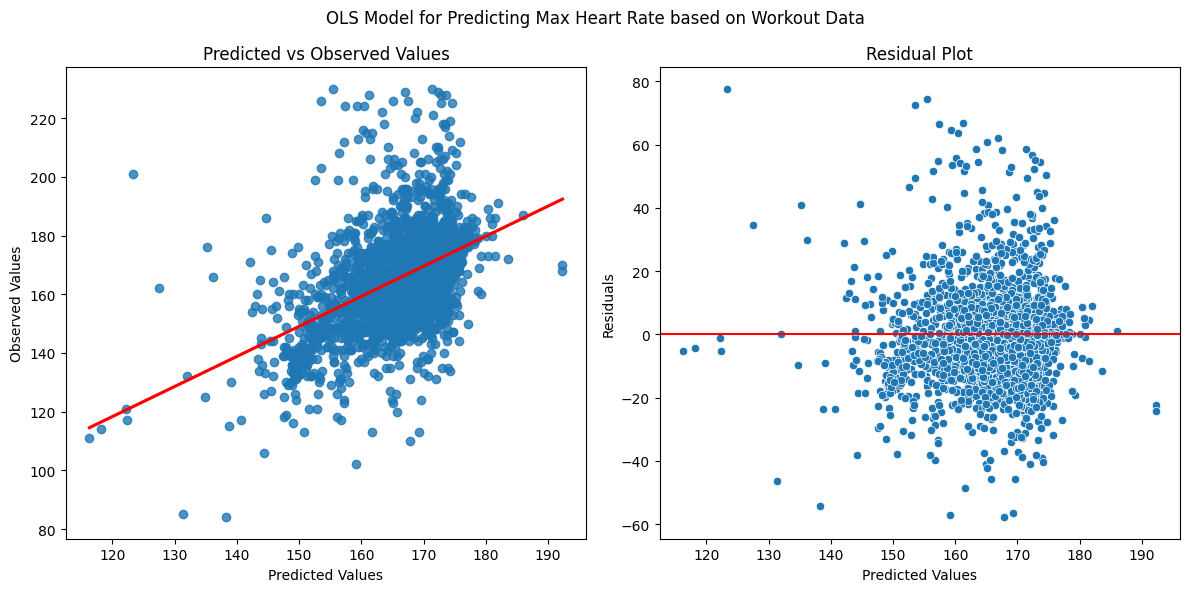

In [124]:
plt.figure(figsize=(12,6))
plt.subplot(121)
# 1. plot predictions vs. observations
sns.regplot(x=y_pred, y=y_test, ci=None, line_kws={'color':'red'});
plt.title("Predicted vs Observed Values")
plt.xlabel("Predicted Values")
plt.ylabel("Observed Values")

plt.subplot(122)
# 2. plot residual plot
sns.scatterplot(x=y_pred, y=y_test - y_pred)
plt.axhline(y=0, color='red')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.suptitle("OLS Model for Predicting Max Heart Rate based on Workout Data")
plt.tight_layout()

Generated a larger RMSE compared to predicting average heart rate.

## Model 2: Calories expenditure prediction using workout metrics

In [125]:
# process data

data = meta_with_hr.drop(columns=["userId", "hydration", "id", "timestamp", "url", "weather", "heart_rate"])
data = data.dropna()

# remove outliers, as there were a few erroneous data points
data = data[data["calories"] < 5000]
data = data[data["calories"] > 10]
data = data[data["max_hr"] >= 60]
data = data[data["max_hr"] <= 230]

# take log of calories and duration
y = np.log(data["calories"])
data["duration"] = np.log(data["duration"])

# drop y data and HR columns (as HR is used to calculate calories)
data = data.drop(columns=["mean_hr", "calories", "max_hr"])
data = data.dropna()
data

,sport,ascent,descent,duration,distance,gender
0,run,35.0,39.0,7.628308,3.90636,male
2,bike,344.0,355.0,8.678601,36.73035,male
3,bike,392.0,378.0,8.514498,39.90147,male
4,run,28.0,29.0,7.851369,3.13272,male
5,bike,163.0,167.0,7.939668,21.47972,male
...,...,...,...,...,...,...
9996,mountain bike,476.0,476.0,8.621193,23.36000,male
9997,bike (transport),42.0,33.0,6.633318,4.34000,male
9998,elliptical,2.0,5.0,6.665684,3.40000,male
9999,bike,80.0,80.0,7.818430,18.99000,male


In [126]:
data = process_data(data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [127]:
# perform 3-fold cross validation
X = data

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=3, shuffle=True)
cal_model = LinearRegression()
val_errors = []
train_errors = []
for train_idx, valid_idx in kf.split(X_train):

    # split data into training and validation
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # fit to training data
    cal_model.fit(split_X_train, split_Y_train)

    # calculate and store the training error
    error = mean_squared_error(cal_model.predict(split_X_train), split_Y_train)
    train_errors.append(error)


    # calculate and record the validation error
    error = mean_squared_error(cal_model.predict(split_X_valid), split_Y_valid)
    val_errors.append(error)
print(f"Train error for calories model: {np.mean(train_errors)}")
print(f"Cross-validation error for calories model: {np.mean(val_errors)}")

Train error for calories model: 0.09902017288567655
Cross-validation error for calories model: 0.09974694076959734


In [128]:
# evaluate the model using RMSE on the test data
cal_model.fit(X_train, y_train)
y_pred = cal_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.3209031973988842

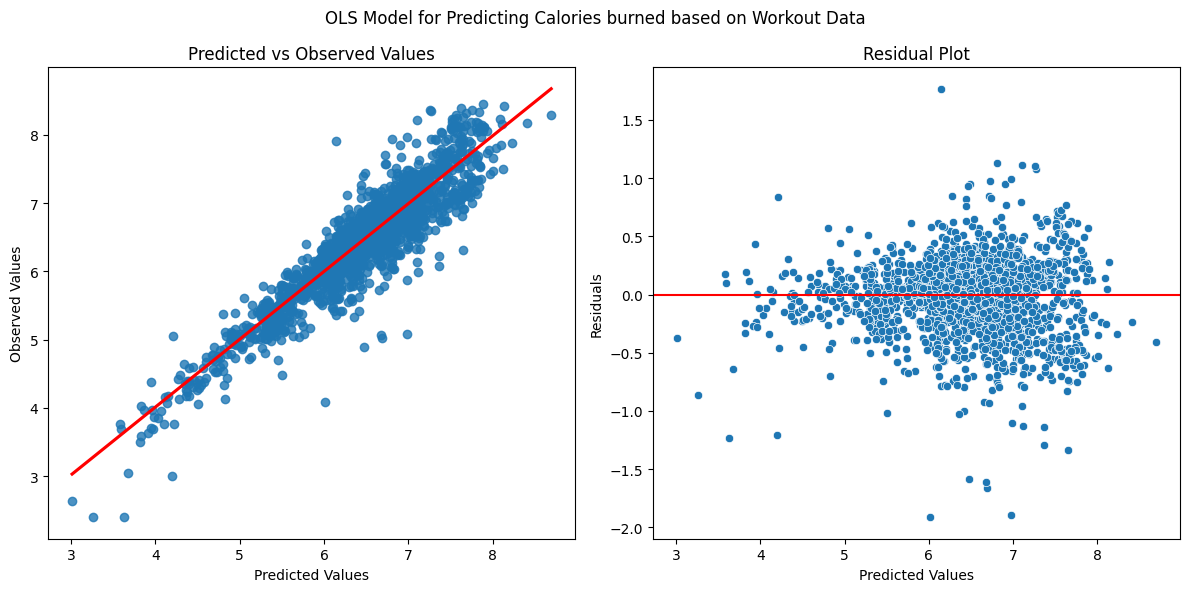

In [130]:
# plot the predictions vs observations and the residual plot

plt.figure(figsize=(12,6))
plt.subplot(121)

# 1. plot predictions vs. observations
sns.regplot(x=y_pred, y=y_test, ci=None, line_kws={'color':'red'});
plt.title("Predicted vs Observed Values")
plt.xlabel("Predicted Values")
plt.ylabel("Observed Values")

plt.subplot(122)
# 2. plot residual plot
sns.scatterplot(x=y_pred, y=y_test - y_pred)
plt.axhline(y=0, color='red')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.suptitle("OLS Model for Predicting Calories burned based on Workout Data")
plt.tight_layout()
plt.savefig("../figures/log_cals_ols.png")

As shown by the plots above, there is some amount of heteroscedasticity, as the variation increases as the log calories value increases, however the model can fairly accurately predict the calorie expenditure based on workout metrics alone.